In [1]:
import tensorflow as tf

print(tf.__version__)

2.6.0


# 1. 자율주행 시스템 만들기
---

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

In [1]:
# 11장에서 썼던 함수 다 불러오기
# functinos_classes.py에 정리해둠

from functions_classes import *

In [2]:
# 학습된 모델 불러오기
num_classes = 8

resnet50_backbone = get_backbone()
model = RetinaNet(num_classes, resnet50_backbone)

model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

# 추론 가능한 모델로 정의
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [3]:
types = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc']
type_dict = {}

for i, type in enumerate(types):
    type_dict[i] = type

In [4]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'


image = tf.keras.utils.load_img(img_path)
image = tf.cast(image, dtype=tf.float32)
input_image, ratio = prepare_image(image)
detections = inference_model.predict(input_image)
num_detections = detections.valid_detections[0]
class_names = [
    type_dict[int(x)] for x in detections.nmsed_classes[0][:num_detections]
]

In [5]:
detected_boxes = detections.nmsed_boxes[0][:num_detections]
detected_boxes[0]

array([849.9934 ,  66.03958, 924.9326 , 234.46005], dtype=float32)

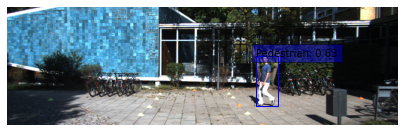

Stop


In [25]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    image = tf.keras.utils.load_img(img_path)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        type_dict[int(x)] for x in detections.nmsed_classes[0][:num_detections]
    ]
    detected_boxes = detections.nmsed_boxes[0][:num_detections]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    for class_name, detected_box in zip(class_names, detected_boxes):
        x1, y1, x2, y2 = detected_box
        
        width = (x2 - x1) / ratio
        height = (y2 - y1) / ratio

        if class_name == 'Pedestrian':
            return 'Stop'
        
        if class_name == 'Car':
            if width >= size_limit or height >= size_limit:
                return 'Stop'
        
    return 'Go'

print(self_drive_assist(img_path))

# 2. 자율주행 시스템 평가하기
---

아래 `test_system()` 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

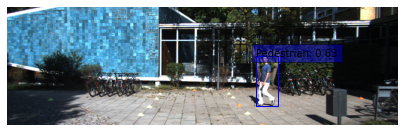

0 / 예측 : Stop / 정답 : Stop / 정답


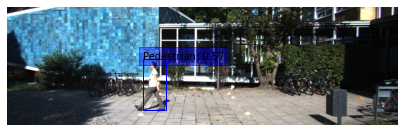

1 / 예측 : Stop / 정답 : Stop / 정답


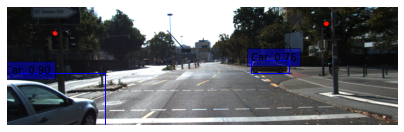

width : 313.27099609375 / height : 163.16990661621094
2 / 예측 : Stop / 정답 : Stop / 정답


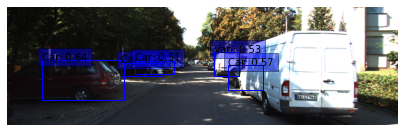

width : 133.0936279296875 / height : 43.072147369384766
width : 260.1153869628906 / height : 125.18816375732422
width : 111.26326751708984 / height : 79.34587097167969
width : 124.6649169921875 / height : 42.88325881958008
3 / 예측 : Go / 정답 : Stop / 오답


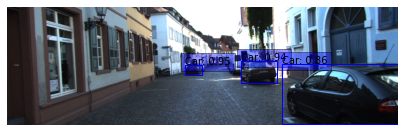

width : 52.86140060424805 / height : 31.683300018310547
width : 113.95667266845703 / height : 71.04878997802734
width : 375.5784606933594 / height : 192.3813018798828
4 / 예측 : Stop / 정답 : Stop / 정답


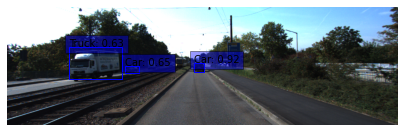

width : 34.2107048034668 / height : 28.68209457397461
width : 41.7482795715332 / height : 22.809032440185547
5 / 예측 : Go / 정답 : Go / 정답


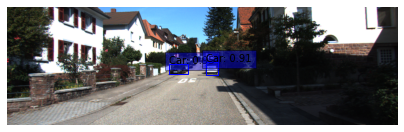

width : 57.88402557373047 / height : 33.06986618041992
width : 38.28862762451172 / height : 39.86442565917969
6 / 예측 : Go / 정답 : Go / 정답


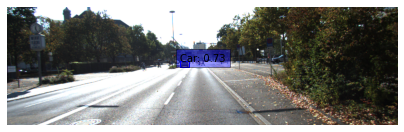

width : 27.844032287597656 / height : 19.94977569580078
7 / 예측 : Go / 정답 : Go / 정답


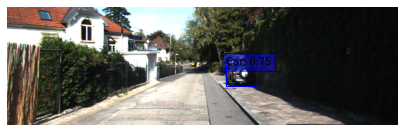

width : 100.01673126220703 / height : 66.61680603027344
8 / 예측 : Go / 정답 : Go / 정답


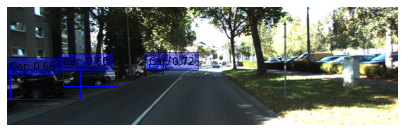

width : 45.137325286865234 / height : 26.33493423461914
width : 221.14125061035156 / height : 93.21378326416016
width : 172.1108856201172 / height : 65.16202545166016
9 / 예측 : Go / 정답 : Go / 정답
90점입니다.


In [24]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for i, test in enumerate(test_set):
        image_file, answer = test
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        result = "오답"
        if pred == answer:
            score += 10
            result = "정답"
        print(f"{i} / 예측 : {pred} / 정답 : {answer} / {result}")
    print(f"{score}점입니다.")

test_system(self_drive_assist)

>3번째 맨 앞에 있는 차는 탐지가 안됨  

작은 오브젝트도 아닌데 왜 못잡을까??  
이것뿐만 아니라 다른 것들도 confidence score가 낮게 나옴.  
학습이 더 필요할 것 같다.

산님은 따로 epoch 10~15번정도 더 돌리고, 그 모델을 사용하셨는데 결과가 훨씬 좋다.  
(confidence score도 1에 가깝게 나오고, 3번에서 흰색 벤도 잘 감지했다.)

---
- 노드에서 제공하는 모델이 추론한 결과

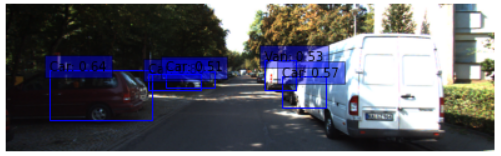



- 추가학습한 모델로 추론한 결과
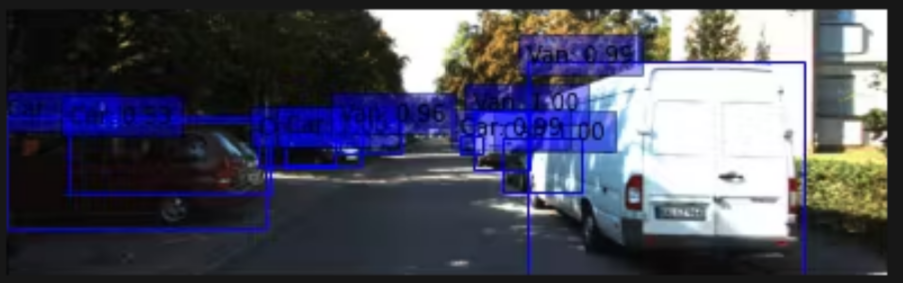


# 회고

---

object detection이라는 분야를 당연히 2일만에 익숙해진다는 건 말이 안된다.  
그래서 키워드 중심으로 가볍게 보려고 했지만, 가볍운게 가볍지 않았다.  
프로젝트는 코드가 주어지고, 이걸 활용해보는 정도라 어렵지 않았지만, 사용된 함수들과 클래스들을 이해하기엔 너무 어려웠다.  
그래도 조금이나마 object detection을 활용해볼 수 있어서 좋았다.   
재밌다 😀👍